In [5]:
import csv
import matplotlib.pyplot as plt
import math
import pandas as pd
def readf(file):
    measures = pd.read_csv('{}.csv'.format(file), parse_dates=True, names=['Timestamp', 'PressureBottom', 'TemperatureBottom', 'ParticleBottom', 'Reflectie', 'Airflow', 'CO2Bottom', 'COBottom', 'PressureTop', 'TemperatureTop','COTop','CO2Top','ParticleTop','nc1','nc2'], index_col=0, header=None)
    events   = pd.read_csv('{}.event.csv'.format(file), parse_dates=True, names=['Timestamp', 'event'], index_col=0, header=None)
    return (measures,events)

def plot_events_on_measures(measurement_plot, events):
    ax2 = measurement_plot[-1].twiny()
    ax2.spines["bottom"].set_position(("axes", -0.5))
    ax2.xaxis.set_ticks_position("bottom")
    ax2.spines["bottom"].set_visible(True)
    xticks = []
    xlabels = []
    for index, event in events.iterrows():
        size = 0
        for p in measurement_plot:
            p.axvline(x=index, alpha=.5)
        xticks.append(index)
        xlabels.append(event[0])
    ax2.set_xticks(xticks)
    ax2.set_xlim(xticks[0], xticks[-1])
    ax2.set_xticklabels(xlabels, rotation=45, color='blue')

def plot_measures(measurements, events, figureNumber = 0, **kwargs):
    plot = measurements.plot.line(subplots=True, **kwargs)
    if len(events) != 0:
        plot_events_on_measures(plot, events)

def filter_range(startEvent, dande):
    s = dande[1].where(lambda x: x == startEvent).first_valid_index()
    ee = dande[1].shift(-1).loc[s]
    e = dande[1].where(lambda x: x==ee).first_valid_index()
    return dande[0].between_time(s.time(),e.time()),dande[1].between_time(s.time(),e.time())

def normalize_start(range1, range2):
    r1 = range1.copy()
    r2 = range2.copy()
    r1start = r1.index[0]
    r2start = r2.index[0]
    diff = r2start - r1start
    r1.index = r1.index.map(lambda x:x+diff)
    return (r1, r2)

def startOffsetRemoval(r):
    offset = r.rolling("1s").mean()[0];
    return r.map(lambda x:x-offset)

In [7]:
dirtyFilter = readf("dirty_filter") #gedaan op 29 Maart
cleanFilter = readf("clean_filter") #gedaan op 29 Maart
weekLater   = readf("1_week_later_connectedv2") #gedaan op 8 April

meteoData   = pd.read_csv('../weer_tijdens_onderzoek.txt', names=['Stn','Date','Hour','FH','FF','FX','P'],comment="#", header=None)
d1Meteo     = meteoData[meteoData["Date"] == 20190325]
d1AvgPressure = d1Meteo.P.mean() * 10 
d2Meteo     = meteoData[meteoData["Date"] == 20190405]
d2AvgPressure = d2Meteo.P.mean() * 10

In [3]:
d1Meteo.describe()

Stn        Date       Hour         FH         FF         FX  \
count   24.0        24.0  24.000000  24.000000  24.000000   24.00000   
mean   260.0  20190325.0  12.500000  55.833333  55.000000  121.25000   
std      0.0         0.0   7.071068  14.116493  16.681153   31.11165   
min    260.0  20190325.0   1.000000  40.000000  30.000000   70.00000   
25%    260.0  20190325.0   6.750000  40.000000  40.000000   97.50000   
50%    260.0  20190325.0  12.500000  60.000000  55.000000  125.00000   
75%    260.0  20190325.0  18.250000  62.500000  60.000000  150.00000   
max    260.0  20190325.0  24.000000  80.000000  90.000000  170.00000   

                  P  
count     24.000000  
mean   10252.541667  
std       37.542995  
min    10207.000000  
25%    10215.250000  
50%    10247.000000  
75%    10284.000000  
max    10317.000000

In [4]:
d2Meteo.describe()


Stn        Date       Hour         FH         FF         FX  \
count   24.0        24.0  24.000000  24.000000  24.000000  24.000000   
mean   260.0  20190405.0  12.500000  30.000000  30.416667  53.333333   
std      0.0         0.0   7.071068  10.632191  11.970677  20.144406   
min    260.0  20190405.0   1.000000  10.000000  10.000000  20.000000   
25%    260.0  20190405.0   6.750000  20.000000  20.000000  37.500000   
50%    260.0  20190405.0  12.500000  30.000000  30.000000  60.000000   
75%    260.0  20190405.0  18.250000  40.000000  40.000000  70.000000   
max    260.0  20190405.0  24.000000  50.000000  50.000000  80.000000   

                  P  
count     24.000000  
mean   10065.583333  
std        6.135546  
min    10056.000000  
25%    10061.750000  
50%    10064.500000  
75%    10070.000000  
max    10078.000000

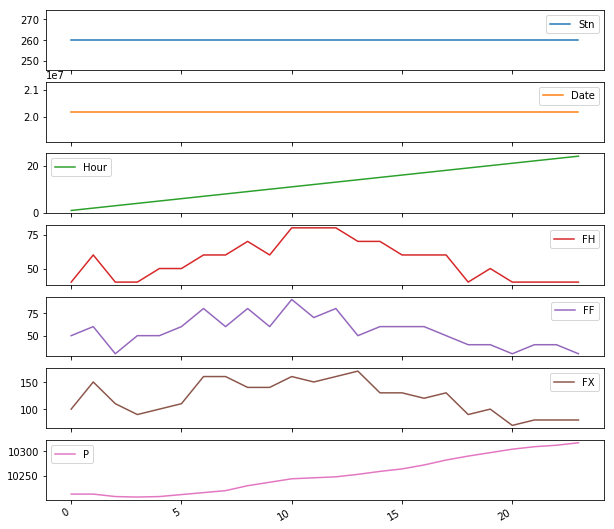

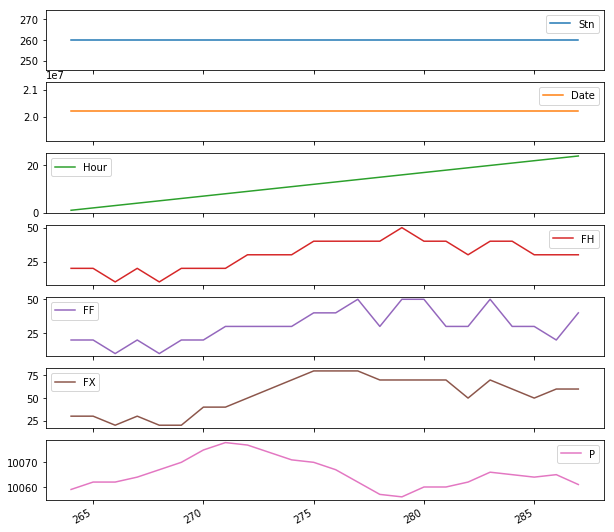

In [5]:
d1Meteo.plot(subplots=True,figsize=(10,10))
d2Meteo.plot(subplots=True,figsize=(10,10))
None

Daling Pressures tijdens aanzet

count    671.000000
mean    -112.786549
std       15.279229
min     -126.368421
25%     -119.157895
50%     -117.368421
75%     -113.921053
max      -60.181818
dtype: float64

count    579.000000
mean     -94.049649
std       14.558913
min     -105.526316
25%     -103.473684
50%      -98.842105
75%      -91.947368
max      -45.842105
dtype: float64

count    571.000000
mean    -110.335708
std       13.394321
min     -123.157895
25%     -117.789474
50%     -115.210526
75%     -109.894737
max      -64.421053
dtype: float64


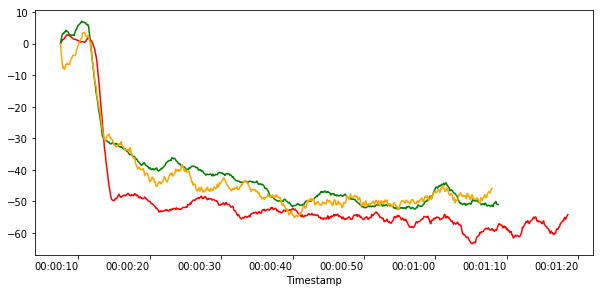

In [26]:
d1,e1=filter_range("laser aan",dirtyFilter)
d2,e2=filter_range("laser aan",cleanFilter)
d3,e3=filter_range("laser aan",weekLater)
d1 = d1.rolling("2s").mean()
d2 = d2.rolling("2s").mean()
d3 = d3.rolling("2s").mean()
dn1, dn2 = normalize_start(d1,d2)
dn3 = normalize_start(d3, dn1)[0]


print("Daling Pressures tijdens aanzet")
print()
print((d1.PressureTop - d1.PressureBottom).describe())
print()
print((d2.PressureTop - d2.PressureBottom).describe())
print()
print((d3.PressureTop - d3.PressureBottom).describe())
plot_measures(startOffsetRemoval(dn1.PressureTop - dn1.PressureBottom),[],color="red",figsize=(10,5))
plot_measures(startOffsetRemoval(dn2.PressureTop - dn2.PressureBottom),[],color="green",figsize=(10,5))
plot_measures(startOffsetRemoval(dn3.PressureTop - dn3.PressureBottom),[],color="orange",figsize=(10,5))

Daling CO2 tijdens laseren hout

count    204.000000
mean    -174.146801
std        1.000907
min     -175.894737
25%     -174.947368
50%     -174.473684
75%     -173.881579
max     -172.000000
dtype: float64

count    178.000000
mean    -124.347559
std        2.894191
min     -128.105263
25%     -127.355263
50%     -124.421053
75%     -121.328947
max     -119.894737
dtype: float64

count    387.000000
mean      16.271144
std        4.524830
min       11.421053
25%       12.526316
50%       14.000000
75%       20.657895
max       25.000000
dtype: float64


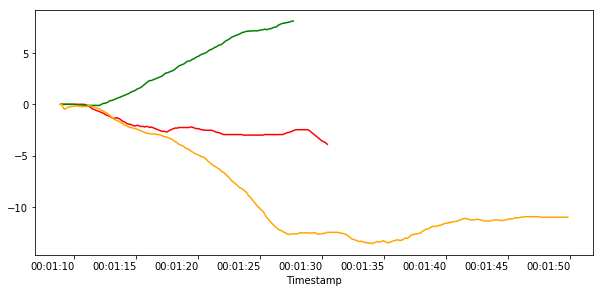

In [7]:
d1,e1=filter_range("laser hout start",dirtyFilter)
d2,e2=filter_range("laser hout start",cleanFilter)
d3,e3=filter_range("laser hout start",weekLater)
d1 = d1.rolling("2s").mean()
d2 = d2.rolling("2s").mean()
d3 = d3.rolling("2s").mean()
dn1, dn2 = normalize_start(d1,d2)
dn3 = normalize_start(d3, dn1)[0]


print("Daling CO2 tijdens laseren hout")
print()
print((d1.CO2Top - d1.CO2Bottom).describe())
print()
print((d2.CO2Top - d2.CO2Bottom).describe())
print()
print((d3.CO2Top - d3.CO2Bottom).describe())
plot_measures(startOffsetRemoval(dn1.CO2Top - dn1.CO2Bottom),[],color="red",figsize=(10,5))
plot_measures(startOffsetRemoval(dn2.CO2Top - dn2.CO2Bottom),[],color="green",figsize=(10,5))
plot_measures(startOffsetRemoval(dn3.CO2Top - dn3.CO2Bottom),[],color="orange",figsize=(10,5))

Daling Particles tijdens laser

count    239.000000
mean      -2.752203
std        4.358135
min      -10.315789
25%       -6.105263
50%       -3.263158
75%       -0.131579
max        8.473684
dtype: float64

count    320.000000
mean      -5.671948
std        6.923032
min      -30.263158
25%       -8.328947
50%       -4.552632
75%       -1.171053
max        5.789474
dtype: float64

count    192.000000
mean     -98.589576
std       19.956841
min     -133.526316
25%     -110.605263
50%     -102.473684
75%      -90.315789
max      -50.923077
dtype: float64


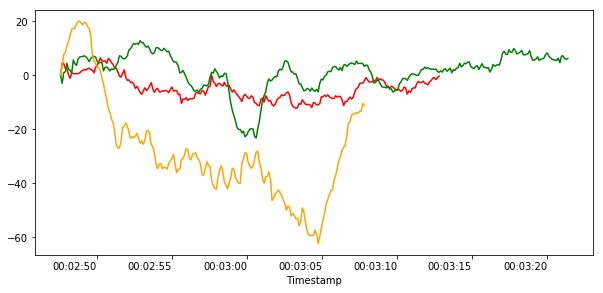

In [25]:
d1,e1=filter_range("laser acryl start",dirtyFilter)
d2,e2=filter_range("laser acryl start",cleanFilter)
d3,e3=filter_range("laser acryl start",weekLater)
d1 = d1.rolling("2s").mean()
d2 = d2.rolling("2s").mean()
d3 = d3.rolling("2s").mean()
dn1, dn2 = normalize_start(d1,d2)
dn3 = normalize_start(d3, dn1)[0]


print("Daling Particles tijdens laser")
print()
print((d1.ParticleTop - d1.ParticleBottom).describe())
print()
print((d2.ParticleTop - d2.ParticleBottom).describe())
print()
print((d3.ParticleTop - d3.ParticleBottom).describe())
plot_measures(startOffsetRemoval(dn1.ParticleTop - dn1.ParticleBottom),[],color="red",figsize=(10,5))
plot_measures(startOffsetRemoval(dn2.ParticleTop - dn2.ParticleBottom),[],color="green",figsize=(10,5))
plot_measures(startOffsetRemoval(dn3.ParticleTop - dn3.ParticleBottom),[],color="orange",figsize=(10,5))

Daling Particles tijdens laser

count    2555.000000
mean       -5.967180
std        16.060104
min      -103.368421
25%        -5.368421
50%        -1.368421
75%         1.368421
max        19.105263
dtype: float64

count    2611.000000
mean      -11.091041
std        35.170807
min      -197.842105
25%        -5.026316
50%        -1.105263
75%         1.578947
max        31.842105
dtype: float64

count    1973.000000
mean      -81.733236
std        67.540543
min      -358.947368
25%       -78.210526
50%       -54.526316
75%       -51.894737
max       -40.263158
dtype: float64


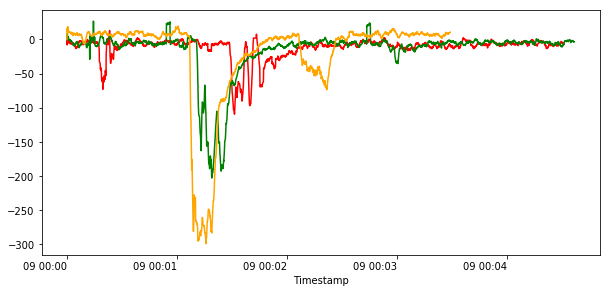

In [15]:
d1,e1=dirtyFilter
d2,e2=cleanFilter
d3,e3=weekLater
d1 = d1.rolling("2s").mean()
d2 = d2.rolling("2s").mean()
d3 = d3.rolling("2s").mean()
dn1, dn2 = normalize_start(d1,d2)
dn3 = normalize_start(d3, dn1)[0]


print("Daling Particles tijdens laser")
print()
print((d1.ParticleTop - d1.ParticleBottom).describe())
print()
print((d2.ParticleTop - d2.ParticleBottom).describe())
print()
print((d3.ParticleTop - d3.ParticleBottom).describe())
plot_measures(startOffsetRemoval(dn1.ParticleTop - dn1.ParticleBottom),[],color="red",figsize=(10,5))
plot_measures(startOffsetRemoval(dn2.ParticleTop - dn2.ParticleBottom),[],color="green",figsize=(10,5))
plot_measures(startOffsetRemoval(dn3.ParticleTop - dn3.ParticleBottom),[],color="orange",figsize=(10,5))

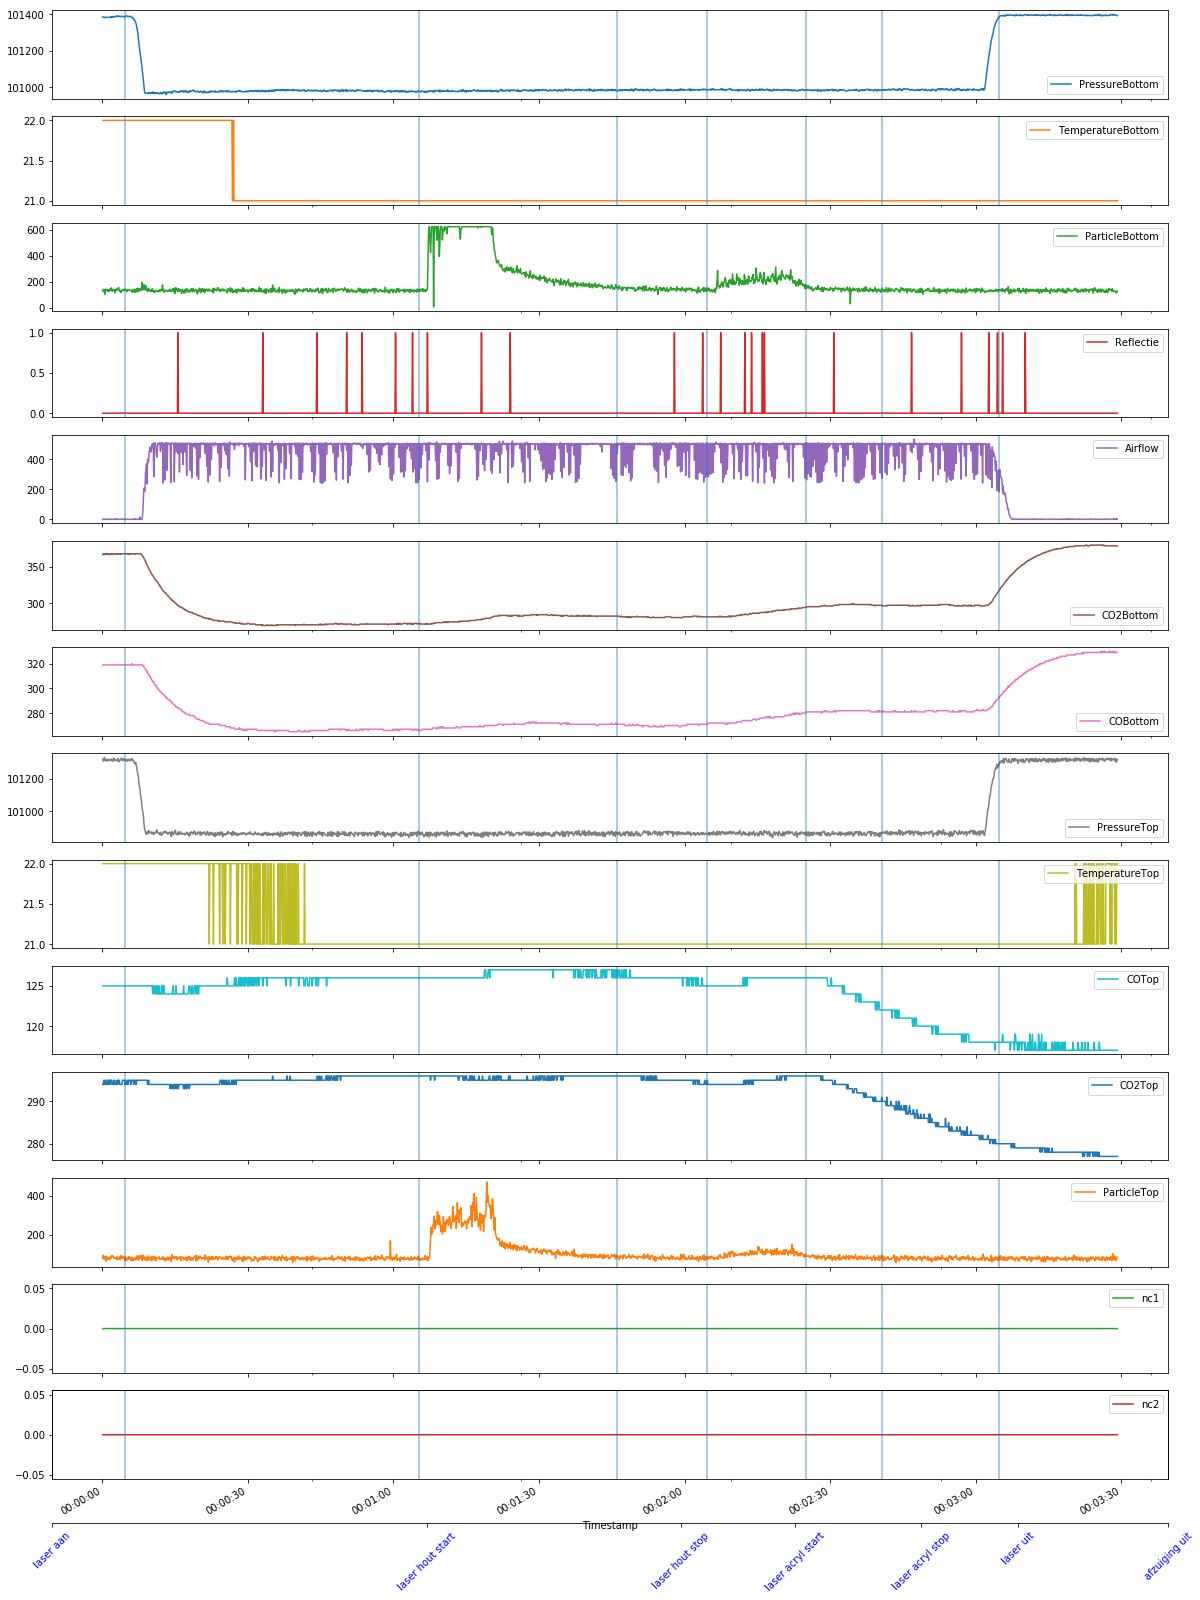

In [10]:
#plot_measures(*cleanFilter,figsize=(20,30))
plot_measures(*weekLater,figsize=(20,30))